In [282]:
import numpy as np; import matplotlib.pyplot as plt
import pymc3 as pm; from pymc3.distributions import Interpolated
import theano.tensor as tt; import pandas as pd 
import theano 
from theano import shared
import os 
# Data in this order 
# Colums of data
# Age, Age Error, 40Ar, 39Ar, 37Ar, 36Ar, Temperature
cwd = os.chdir("/Users/ArgonLab/Documents")
df = pd.read_csv("mix_hb_tcr_acs.csv", engine = 'python') # DATA
age = df.iloc[:,0:1]
age_err = df.iloc[:,1:2]
a40 = df.iloc[:,2:3]
a39 = df.iloc[:,3:4]
a37 = df.iloc[:,4:5]
a36 = df.iloc[:,5:6]
temp = df.iloc[:,6:7]
age = age.values
age_err = age_err.values
a40 = a40.values
a39 = a39.values
a37 = a37.values
a36 = a36.values
temp = temp.values
age = age[age >=0]
age_err = age_err[age_err !=0]
a40 = a40[a40 >= 0]
a39 = a39[a39 >= 0]
a37 = a37[a37 >= 0]
a36 = a36[a36 >= 0]
temp = temp[temp >= 0]
time= 300*np.ones(len(temp))
data = age

In [283]:
def f_obs(a): 
    y = np.cumsum(a)
    v = y/y[-1]
    return v
x = f_obs(a39)

In [284]:
def fracrelx(Ea, D0, a, temp, time): 
    R = 8.314e-3
    D0t = (D0/(a**2))*np.exp(-Ea/(R*temp))*time
    
    q = (6./(np.pi**(3/2)))*np.sqrt((np.pi**2)*D0t)
    
    q1 = (6./(np.pi**(1.5)))*np.sqrt((np.pi**2)*D0t)
    
    q2 = (6./(np.pi**(3/2)))*np.sqrt((np.pi**2)*D0t)\
    - (3./(np.pi**2)) *((np.pi**2)* D0t)
    
    q3 = 1 - (6./(np.pi**2)) *np.exp(-(np.pi**2)*D0t)
     
    
    
    Q = tt.switch(q <= 0.9, q2, q3)
    T = tt.switch(q < 0.1, q, Q)
    
    return T

In [285]:
def Increment(ea, d0, a, temp, t):
    R = 8.314e-3
    
    D0t = (d0/(a**2))*np.exp(-ea/(R*temp))*t
    
    q = (6./(np.pi**(3/2)))*np.sqrt((np.pi**2)*D0t)
    
    aa1 = np.sqrt(np.pi) * R * temp**2
    bb1 = d0*np.exp(-ea/(R*temp))*t
    z1 = (3*ea *np.sqrt(bb1/a**2))/aa1
    

    aa2 = np.sqrt(np.pi) * R *temp**2
    bb2 = d0*np.exp(-ea/(R*temp))*t
    z2 = (3*ea*(np.sqrt(bb2/a**2) - np.sqrt(np.pi)*bb2/a**2))/aa2
      
    
    aa3 = a**2 * R * temp**2
    bb3 = d0*np.exp(-ea/(R*temp))*t
    z3 = 6 * d0 * ea * t * np.exp((-np.pi**2 * bb3/a**2) - ea/(R*temp))/aa3

    
    Q = tt.switch(q <= 0.9,
                z2,
                 z3)
    
    T = tt.switch(q < 0.1, z1, Q)
    
    
    return T

In [286]:
import theano 
from theano import shared, tensor as tt
ar39_err = 0.0015*a39
# Cumulative sum error 
# to cast as theano shared variable then use in model 
def cumul_err(X, Y):
    zz = np.cumsum(Y)
    qq = zz/zz.max()
    
    err = np.sqrt(np.cumsum(X**2))
    z1 = err.max()
    
    y1 = np.sqrt((err/zz)**2 + (err[-1]/zz.max())**2)
    return y1

In [287]:
# Age Data and Fractional Release Data
data = age
# Shared variable for modelling 
data_err = shared(age_err)

data2= x
tempk = temp + 273.15
t_obs = time
N = data.shape[0]


# Plot Data

Text(0, 0.5, 'Apparent Age (Ma)')

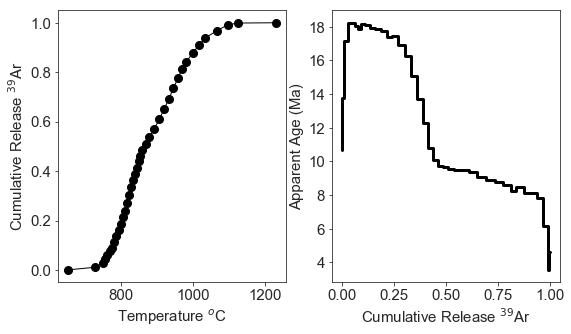

In [288]:
fig, ax = plt.subplots(1, 2, figsize = (9,5))
ax[0].plot(temp, x, 
          lw = 1, marker = 'o', 
          markersize = 8, 
          color = 'k')
ax[1].plot(x, age, 
          drawstyle = 'steps', 
          lw = 3, 
          color = 'k')

ax[0].set_xlabel('Temperature $^{o}$C')
ax[0].set_ylabel('Cumulative Release $^{39}$Ar')
ax[1].set_xlabel('Cumulative Release $^{39}$Ar')
ax[1].set_ylabel('Apparent Age (Ma)')

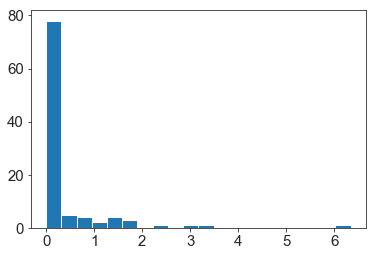

In [289]:
r = np.random.lognormal(-3, 2, 100)
plt.hist(r, bins =20);

In [290]:
marty = pm.Model() 
N = data.shape[0]
with marty: 
    
    # Mixing/Volume Coeffs
    phi = pm.Dirichlet('phi', a = np.array([1,1,1]), 
                      shape = 3)
    
    phi_min = pm.Potential('phi_min', 
                         tt.switch(phi.min() < 0.2, 
                                    -np.inf,
                                    0))
    
    p1 = phi[0]; p2 = phi[1]; p3 = phi[2]
    

    # Diffusion Kinetics 
    ea1 = pm.Normal('ea1', mu = 196, sd = 5)
    ea2 = pm.Normal('ea2', mu = 220, sd = 5)
    ea3 = pm.Normal('ea3', mu = 220, sd = 5)
    
    d01 = pm.Lognormal('d01', -4, 1)    
    d02 = pm.Lognormal('d02', -3, 1)
    d03 = pm.Lognormal('d03', -3, 1)


    a1 = pm.TruncatedNormal('a1', mu = 0.002, sd = 0.001,
                           lower = 0.0005, upper = 0.0032)

    a2 = pm.TruncatedNormal('a2', mu = 0.002, sd = 0.001,
                           lower = 0.0005, upper = 0.0032)
    
    a3 = pm.TruncatedNormal('a3', mu = 0.002, sd = 0.001,
                           lower = 0.0005, upper = 0.0032)
    
    w1 = p1        
    w2 = p2 
    w3 = p3

In [291]:
with marty: 
    
    age1 = pm.Uniform('age1', lower = 0.0, upper = 4600, 
                     testval = 50)
    
    age2 = pm.Uniform('age2', lower = 0.0, upper = 4600, 
                     testval = 5)
   
    age3 = pm.Uniform('age3', lower = 0.0, upper= 4600, 
                     testval = 100)

    
    age_cons = pm.Potential('age_cons', 
                           tt.switch(age3 - age1 < 0, 
                                    -np.inf, 0) + 
                           tt.switch(age1 - age2 < 0, 
                                    -np.inf, 0))


In [292]:
with marty: 
    A = fracrelx(ea1, d01, a1, tempk, t_obs)
    B = fracrelx(ea2, d02, a2, tempk, t_obs)
    C = fracrelx(ea3, d03, a3, tempk, t_obs)
    
    mu = (w1*A + w2*B + w3*C)

   #Monotonicity
    
####################################################################################################
    for i in range(len(data) - 1): 
        Frel_bound_a = pm.Potential(f'f_bound_a{i}', 
                                 tt.switch(A[i +1] - A[i] < 0, 
                                          -np.inf, 0)) 
        Frel_bound_b = pm.Potential(f'f_bound_b{i}', 
                                 tt.switch(B[i +1] - B[i] < 0, 
                                          -np.inf, 0)) 
        Frel_bound_c = pm.Potential(f'f_bound_c{i}', 
                                 tt.switch(C[i +1] - C[i] < 0, 
                                          -np.inf, 0))
        
        
    for i in range(len(data) - 1): 
        f_con_mu = pm.Potential(f'f_bound_mu{i}', 
                               tt.switch(mu[i + 1] - mu[i] < 0, 
                                        -np.inf, 0))  
########################################################################################################
     

In [293]:
### Fractional Release Likelihood
with marty: 
    f_err = pm.HalfNormal('f_err', sd = 0.1)


In [294]:
with marty: 
    X = Increment(ea1, d01, a1, tempk, t_obs)
    Y = Increment(ea2, d02, a2, tempk, t_obs)
    Z = Increment(ea3, d03, a3, tempk, t_obs)
    
    qq = (w1*X + w2*Y + w3*Z)
    
    mu2 = (w1*X*age1)/qq + (w2*Y*age2)/qq + (w3*Z*age3)/qq
    
    age_error_m = pm.HalfNormal('age_error_m', 
                               sd = 2)

In [295]:
# Models 
with marty: 
    f_model  = pm.Deterministic('f_model', mu)
    age_model = pm.Deterministic('age_model', mu2)

In [296]:
def logp(mod, data, err): 
    logp = -tt.sqr(data - mod)/(2 * err * err)
    return logp.sum()

In [297]:
with marty: 
    # Age Spectra Likelihood     
    L2x = pm.Normal('obs1', mu = mu2, 
                   sd = age_error_m, 
                   observed = data)
    
    obs = pm.Normal('obs2', mu = mu, sd = f_err, 
                   observed = data2)

In [298]:
marty.check_test_point()

phi_stickbreaking__     -2.60
ea1                     -2.53
ea2                     -2.53
ea3                     -2.53
d01_log__               -0.92
d02_log__               -0.92
d03_log__               -0.92
a1_interval__           -1.12
a2_interval__           -1.12
a3_interval__           -1.12
age1                    -0.23
age2                     1.67
age3                    -0.23
f_err_log__             -0.77
age_error_m_log__       -0.77
obs1                  -573.04
obs2                  -395.77
Name: Log-probability of test_point, dtype: float64

In [299]:
SAMPLES = 500000
BURN = 250000
SEED = np.random.seed(123)

with marty: 
    
    step1 = pm.Metropolis([age1, age2, age3, phi], 
                         scaling = 0.05)
    step2 = pm.Metropolis([a1, a2, a3], 
                         scaling = 0.05)
    step3 = pm.Metropolis([ea1, ea2, ea3, 
                          d01, d02, d03, 
                          age_error_m,
                          f_err])
    
    trace = pm.sample(SAMPLES, tune = BURN, 
                     step = [step1, step2, 
                            step3], 
                     cores = 3, 
                      random_seed = SEED)

Multiprocess sampling (3 chains in 3 jobs)
CompoundStep
>CompoundStep
>>Metropolis: [phi]
>>Metropolis: [age3]
>>Metropolis: [age2]
>>Metropolis: [age1]
>CompoundStep
>>Metropolis: [a3]
>>Metropolis: [a2]
>>Metropolis: [a1]
>CompoundStep
>>Metropolis: [f_err]
>>Metropolis: [age_error_m]
>>Metropolis: [d03]
>>Metropolis: [d02]
>>Metropolis: [d01]
>>Metropolis: [ea3]
>>Metropolis: [ea2]
>>Metropolis: [ea1]
Sampling 3 chains: 100%|██████████| 2250000/2250000 [2:53:58<00:00, 115.83draws/s]  
The number of effective samples is smaller than 10% for some parameters.


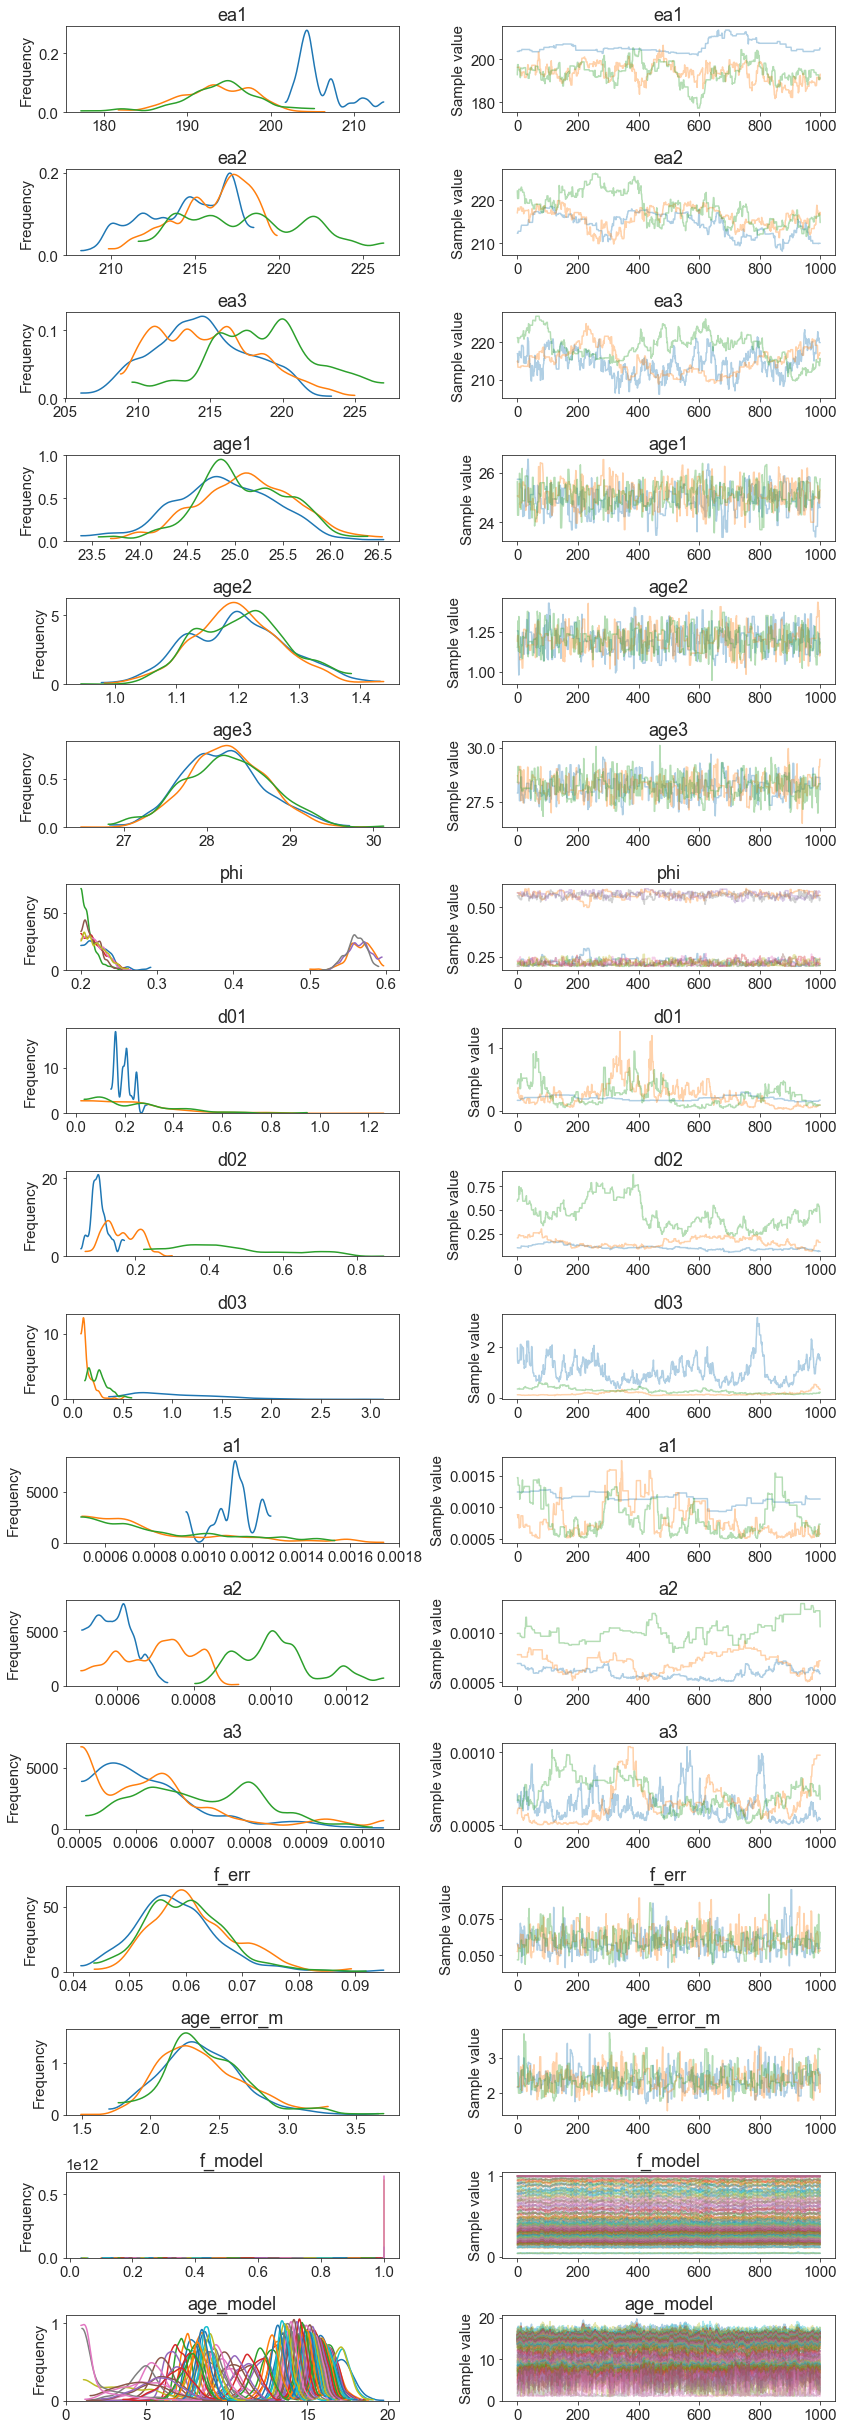

In [300]:
sns.set_style("ticks")

font = {"weight" : "normal", 
       "size" : 15, 
       "family": "Arial"}

plt.rc("font", **font)

import seaborn as sns
pm.traceplot(trace[-1000:]); 

# Post Posterior Check 
* Post Posterior Checks (PPCs) are a great way to validate a model. Here we generate data from the model using parameters that are drawn from the posterior. 
* This allow a visual check on how the the model deviates/fits the oberved data. 

# PPC plot
* Plotting of the post posterior model and its 95% credible interva with comparison to the original data 

In [301]:
with marty: 
    ppc = pm.sample_ppc(trace[-10000:], 
                       5000)

/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: DeprecationWarning: sample_ppc() is deprecated.  Please use sample_posterior_predictive()
  This is separate from the ipykernel package so we can avoid doing imports until
100%|██████████| 5000/5000 [00:46<00:00, 108.54it/s]


In [302]:
# 95% Credible Interval 

low2, high2 = np.percentile(ppc['obs2'],
                            [30, 60], axis = 0)
low1, high1 = np.percentile(ppc['obs1'],
                            [10, 90], axis = 0)

In [303]:
# Mean Posterior Models

Z2 = ppc['obs2'].mean(axis = 0)
Z1 = ppc['obs1'].mean(axis = 0)

In [304]:
# Fractional Release Data Frame
df = pd.DataFrame({'f_mod': Z2, 
                  "f_low": low2, 
                  "f_high": high2})

In [305]:
df.to_csv('f_mod_hb_ac_tcr.csv')

# Plots

In [306]:
# Plotting Parameters Fonts

font = {'family' : 'Arial',
        'weight' : 'normal',
        'size'   : 15}

plt.rc('font', **font)
import seaborn as sns
sns.set_style('ticks')

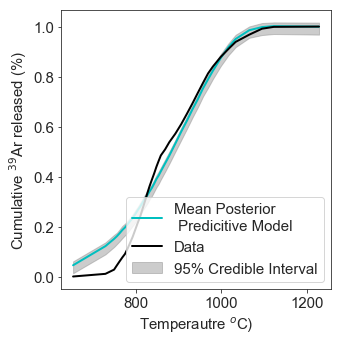

In [307]:
# Fractional release plot
plt.figure(figsize = (5,5))
plt.fill_between(temp, low2, high2, alpha = 0.4, 
                color = 'grey', 
                label = '95% Credible Interval')
plt.plot(temp, Z2, 'c', lw = 2, 
        label = 'Mean Posterior \n Predicitive Model')

plt.plot(temp, data2, lw = 2, color= 'k', 
        label = 'Data')
plt.ylabel('Cumulative $^{39}$Ar released (%)')
plt.xlabel('Temperautre $^{o}$C)')
plt.legend(loc = 'best')
plt.tight_layout()
        

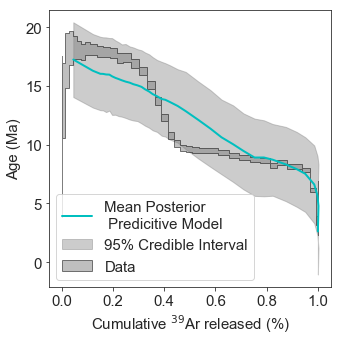

In [308]:
# Age Spectra plot
plt.figure(figsize = (5,5))
plt.fill_between(Z2, low1, high1, alpha = 0.4, 
                color = 'grey', 
                label = '95% Credible Interval')
plt.plot(Z2, Z1, 'c', 
        lw = 2, 
        label = 'Mean Posterior \n Predicitive Model')
plt.fill_between(data2, data - age_err, data + age_err, 
                step ='pre', 
                facecolor = 'grey', 
                alpha = 0.5, 
                edgecolor = 'k', 
                label = 'Data')

plt.xlabel('Cumulative $^{39}$Ar released (%)')
plt.ylabel('Age (Ma)')
plt.legend(loc = 'best')
plt.tight_layout()


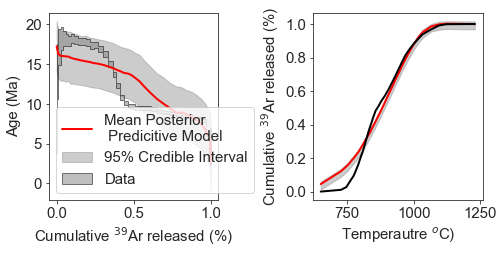

In [309]:
# Joint Summary Plots

# AGE SPECTRA
fig, ax = plt.subplots(1,2, figsize = (7.1, 3.75))

ax[0].fill_between(data2, low1, high1, alpha = 0.4, 
                color = 'grey', 
                label = '95% Credible Interval')
ax[0].plot(data2, Z1, 'r', 
        lw = 2, 
        label = 'Mean Posterior \n Predicitive Model')
ax[0].fill_between(data2, data - age_err, data + age_err, 
                step ='pre', 
                facecolor = 'grey', 
                alpha = 0.5, 
                edgecolor = 'k', 
                label = 'Data')

ax[0].set_xlabel('Cumulative $^{39}$Ar released (%)')
ax[0].set_ylabel('Age (Ma)')
ax[0].legend(loc = 'best')



# Fractional Release
ax[1].fill_between(temp, low2, high2, alpha = 0.4, 
                color = 'grey', 
                label = '95% Credible Interval')
ax[1].plot(temp, Z2, 'r', lw = 2, 
        label = 'Mean Posterior \n Predicitive Model')

ax[1].plot(temp, data2, lw = 2, color= 'k', 
        label = 'Data')
ax[1].set_ylabel('Cumulative $^{39}$Ar released (%)')
ax[1].set_xlabel('Temperautre $^{o}$C)')



plt.tight_layout()
plt.savefig('hb_tcr_acs.pdf')

In [272]:
print(trace['age1'][-1500:].mean(axis = 0))
print(trace['age2'][-500:].mean(axis = 0))
print(trace['age3'][-1500:].mean(axis = 0))

25.471179405270085
1.2248764303213402
28.889866769085938


In [273]:
print(2*np.std(trace['age1'][-1500:]))
print(2*np.std(trace['age2'][-50:]))
print(2*np.std(trace['age3'][-1500:]))

0.7428911132094376
0.2015896650500805
1.1142159401951446


# Finalised Plots 

In [310]:
# plotting parameters

age_low_plot = np.insert(low1, 0, low1[0])
age_high_plot = np.insert(high1, 0, high1[0])
f_mod_plot = np.insert(Z2, 0, 0)

model_plot = np.insert(Z1, 0, Z1[0])


data_err_plot = np.insert(age_err, 0, age_err[0])
data_plot = np.insert(age, 0, age[0])
f_plot = np.insert(data2, 0, 0)

f_low = low2
f_high = high2

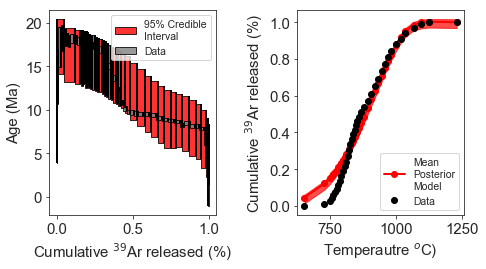

In [311]:
fig, ax = plt.subplots(1, 2, figsize = (7, 4))

ax[0].fill_between(f_mod_plot, age_low_plot, 
                  age_high_plot, 
                  step = 'pre', 
                  alpha = 0.8, 
                  facecolor = 'r', 
                  edgecolor = 'k', 
                  label = '95% Credible\nInterval')

ax[0].fill_between(f_plot, data_plot + data_err_plot,
                  data_plot - data_err_plot, 
                  step = 'pre', 
                  alpha = 0.8, 
                  facecolor = 'grey', 
                  edgecolor = 'k', 
                  label = 'Data')

for i in range(len(data_plot)):
    ax[0].vlines(f_mod_plot, age_low_plot, 
                  age_high_plot,color = 'k', 
                alpha = 0.8)
    ax[0].vlines(f_plot, data_plot + data_err_plot,
                  data_plot - data_err_plot,color = 'k', 
                alpha = 0.8 )
    
ax[1].fill_between(temp, f_low, f_high, 
                  color = 'r', 
                  alpha = 0.7)

ax[1].plot(temp, Z2, '-or', 
          lw = 2, label = 'Mean\nPosterior\nModel')
ax[1].plot(temp, data2, 'ok', 
          label = 'Data')


ax[0].set_xlabel('Cumulative $^{39}$Ar released (%)')
ax[0].set_ylabel('Age (Ma)')
ax[0].legend(loc = 'best', fontsize = "x-small")
ax[1].legend(loc = 'best', fontsize = "x-small" )
ax[1].set_ylabel('Cumulative $^{39}$Ar released (%)')
ax[1].set_xlabel('Temperautre $^{o}$C)')
plt.tight_layout()

In [312]:
df.to_csv("hbd1_acs_tcr_posterior.csv")

In [313]:
df.to_csv("hbd1_acs_tcr_marty.csv")
df2 = pm.trace_to_dataframe(trace[-1000:])
df2.to_csv("hbd1_acs_tcr_marty_trace.csv")

In [314]:
df2.to_csv("hbd1_acs_tcr_marty_trace.csv")

In [315]:
# Mean Posterior DataFrame
df = pd.DataFrame({"f_model": Z1, 
                  'low_bound':low1, 
                  'high_bound':high1, 
                  "age_model":Z2, 
                  "lb_age": low2, 
                  "hb_age":high2, 
                  "fel": data2, 
                  "age_data":data, 
                  "age_err": age_err, 
                  "temp": temp})
df.to_csv("hbd1_acs_tcr_posterior.csv")
# Trace_DataFrame
df1 = pm.trace_to_dataframe(trace)

In [316]:
df1 = df2[-10000:]

In [317]:
df = pd.DataFrame({"age1":df1['age1'].values, 
                   "age2":df1['age2'].values, 
                   "age3":df1['age3'].values,
                   "ea1":df1['ea1'].values, 
                   "ea2":df1['ea2'].values,
                   "ea3":df1['ea3'].values,
                   "d01":df1['d01'].values,
                   "d02":df1['d02'].values,
                   "d03":df1['d03'].values})

# PairGrid Plot

In [319]:
font = {"family": "Arial", 
       "weight": "normal", 
       "size": 16}

plt.rc("font", **font)

<Figure size 538.582x538.582 with 0 Axes>

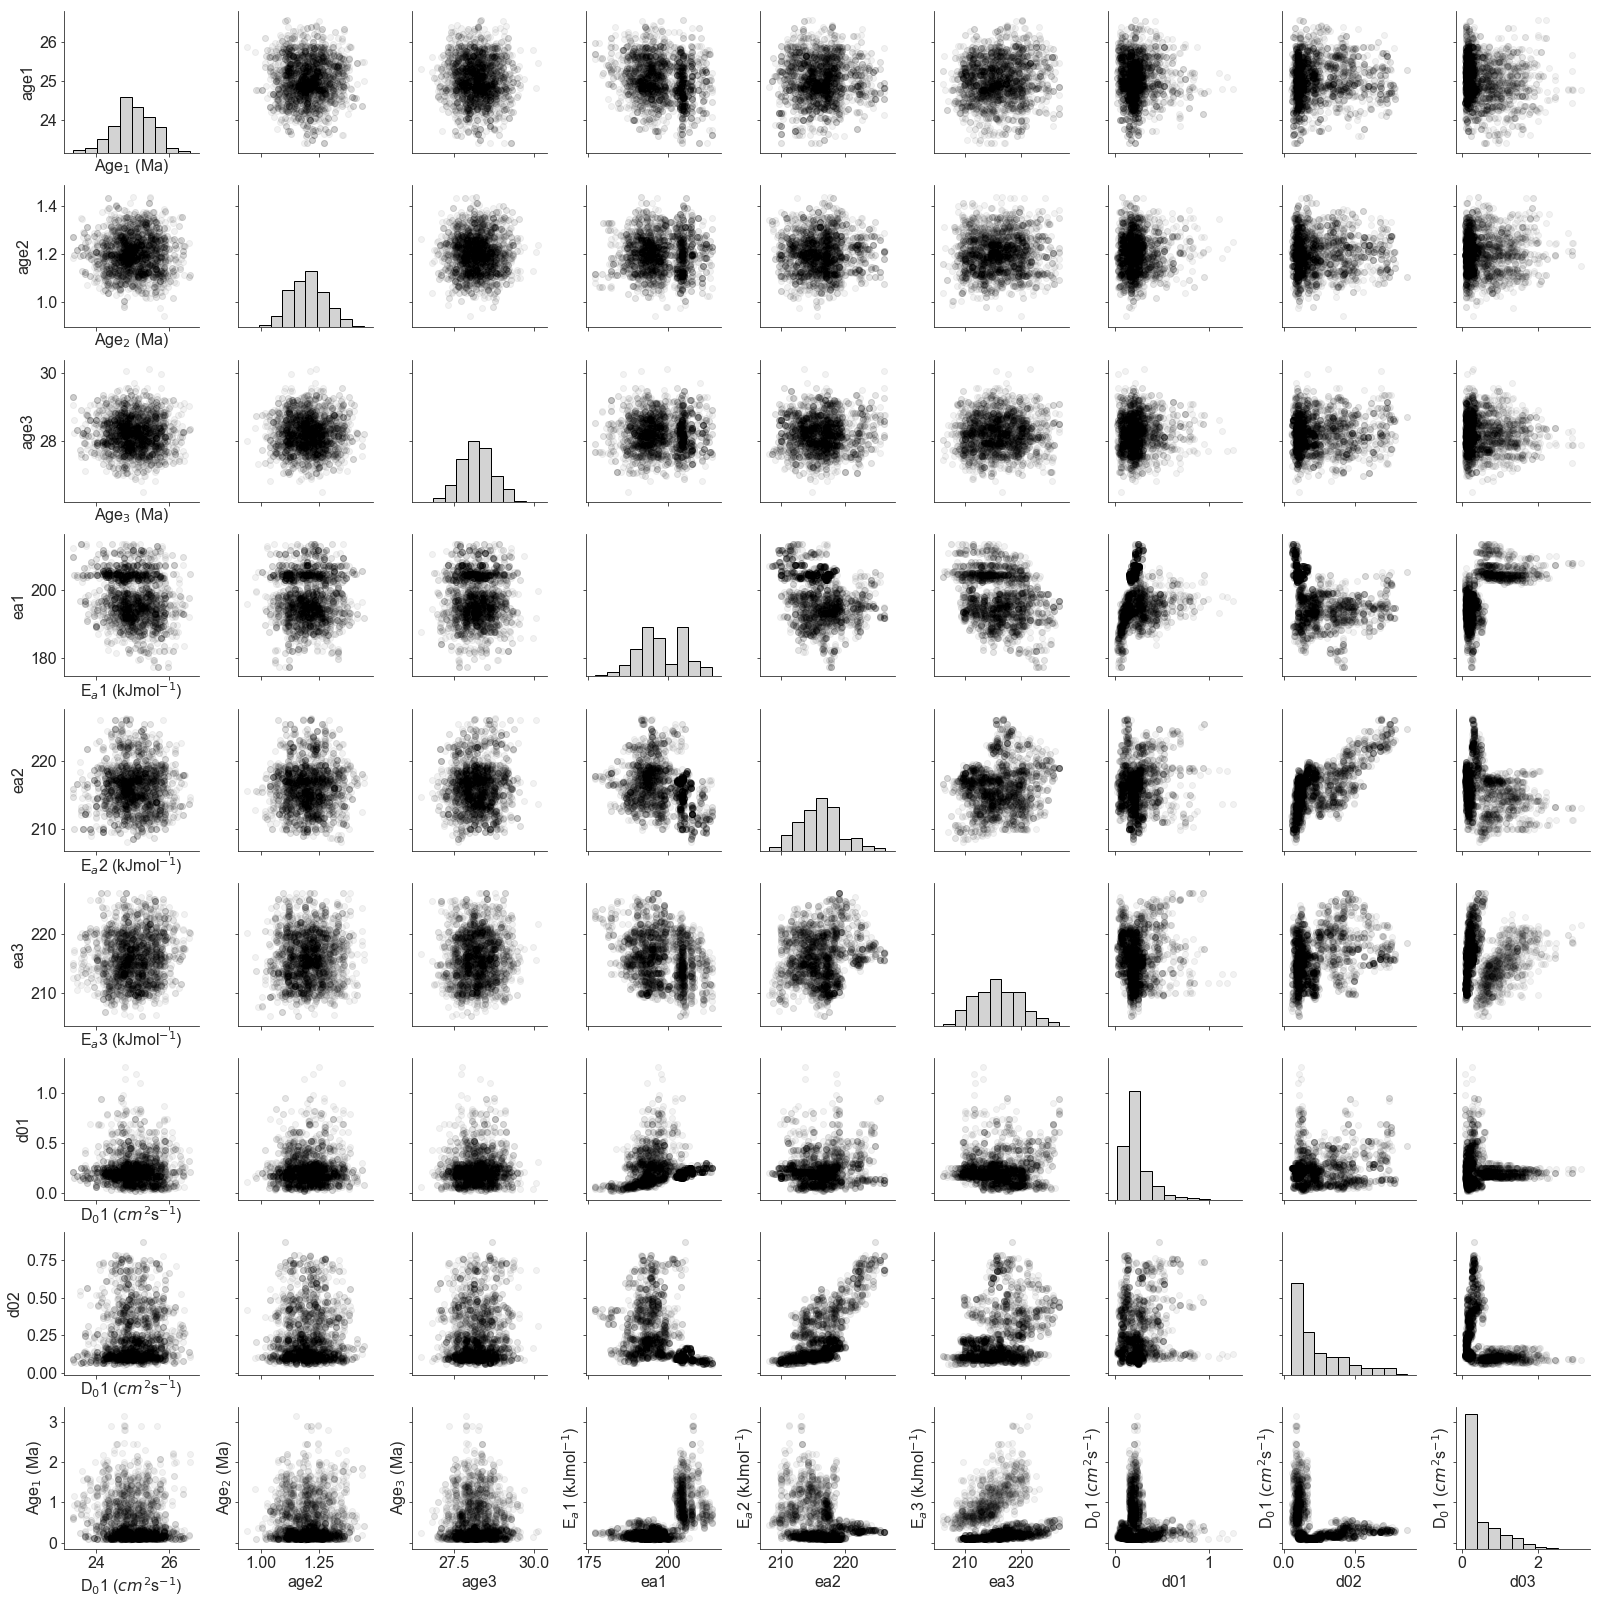

In [323]:
import seaborn as sns
plt.figure(figsize = (7.48031, 7.48031))
g = sns.PairGrid(df[-5000:])
g = g.map_diag(plt.hist, facecolor  = 'lightgrey', 
              edgecolor = 'k')
g = g.map_offdiag(plt.scatter, color = 'k', 
                 alpha = 0.05)


# y-axis labels 
g.axes[0,0].set_ylabel('Age$_1$ (Ma)')
g.axes[1,0].set_ylabel('Age$_2$ (Ma)')
g.axes[2,0].set_ylabel('Age$_3$ (Ma)')
g.axes[3,0].set_ylabel('E$_a$1 (kJmol$^{-1}$)')
g.axes[4,0].set_ylabel('E$_a$2 (kJmol$^{-1}$)')
g.axes[5,0].set_ylabel('E$_a$3 (kJmol$^{-1}$)')
g.axes[6,0].set_ylabel('D$_0$1 ($cm^{2}$s$^{-1}$)')
g.axes[7,0].set_ylabel('D$_0$1 ($cm^{2}$s$^{-1}$)')
g.axes[8,0].set_ylabel('D$_0$1 ($cm^{2}$s$^{-1}$)')


# x-axis labels 
g.axes[8,0].set_xlabel('Age$_1$ (Ma)')
g.axes[8,1].set_xlabel('Age$_2$ (Ma)')
g.axes[8,2].set_xlabel('Age$_3$ (Ma)')
g.axes[8,3].set_label('E$_a$1 (kJmol$^{-1}$)')
g.axes[8,4].set_ylabel('E$_a$2 (kJmol$^{-1}$)')
g.axes[8,5].set_ylabel('E$_a$3 (kJmol$^{-1}$)')
g.axes[8,6].set_ylabel('D$_0$1 ($cm^{2}$s$^{-1}$)')
g.axes[8,7].set_ylabel('D$_0$1 ($cm^{2}$s$^{-1}$)')
g.axes[8,8].set_ylabel('D$_0$1 ($cm^{2}$s$^{-1}$)')





plt.savefig('PairGrid_HB_TCR_ACS.pdf')

In [321]:
df.to_csv('hb_acs_tcr_post.csv')


In [322]:
df1.to_csv('hb_acs_tcr_trace.csv')